### Project 3

The main challenge is to design attacks that are subtle or imperceptible; that is, the perturbed test image should resemble the original test image as much as possible. Mathematically, we require that the distance (measured in some sense) between the original and perturbed images is small. Typical measures of distance in this context are the $L_\infty$ distance (which upper‐bounds how much each image pixel is allowed to be perturbed; these are called $L_\infty$ or *pixel‐wise* attacks) and the $L_0$ distance (which upper‐bounds how many pixels are allowed to be perturbed; these are called $L_0$ or *patch* attacks).

Doc: https://arxiv.org/pdf/2307.02055

In [10]:
#!pip install sympy==1.12
#!pip install transformers
!pip install tqdm
from tqdm import tqdm

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
from PIL import Image

In [2]:
#prepare the data
!unzip TestDataSet.zip -x "__MACOSX/*"

Archive:  TestDataSet.zip
   creating: TestDataSet/
   creating: TestDataSet/n02795169/
   creating: TestDataSet/n02769748/
   creating: TestDataSet/n02834397/
   creating: TestDataSet/n02917067/
   creating: TestDataSet/n02808304/
   creating: TestDataSet/n03016953/
   creating: TestDataSet/n02793495/
   creating: TestDataSet/n02814533/
   creating: TestDataSet/n02837789/
   creating: TestDataSet/n02840245/
   creating: TestDataSet/n02992211/
   creating: TestDataSet/n02701002/
   creating: TestDataSet/n02870880/
   creating: TestDataSet/n02804414/
   creating: TestDataSet/n02909870/
   creating: TestDataSet/n02910353/
   creating: TestDataSet/n02977058/
   creating: TestDataSet/n02859443/
   creating: TestDataSet/n02950826/
  inflating: TestDataSet/.DS_Store   
   creating: TestDataSet/n02804610/
   creating: TestDataSet/n03018349/
   creating: TestDataSet/n02786058/
   creating: TestDataSet/n02794156/
   creating: TestDataSet/n03017168/
   creating: TestDataSet/n02790996/
   creatin

In [3]:
import requests
response = requests.get("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt")
imagenet_classes = [line.strip() for line in response.text.splitlines()]
imagenet_idx_to_name = {i: name for i, name in enumerate(imagenet_classes)}

In [4]:
import json, os

DATA_DIR = "TestDataSet"

with open(os.path.join(DATA_DIR, "labels_list.json"), 'r') as f:
    label_list = json.load(f)

# Example format: "401: accordion"
idxs = [int(s.split(":", 1)[0]) for s in label_list]
wnids = sorted(
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d)) and d.startswith("n")
)
wnid_to_idx = dict(zip(wnids, idxs))

#### Task 1: Basics

The goal is to **attack a ResNet-34 model** that is trained to classify the **ImageNet-1K** dataset.

ImageNet-1K is a well-known dataset in computer vision research with visually challenging images from **1,000 classes**, and networks trained on ImageNet typically also perform well on other tasks.

##### Step 1: Download the Pretrained Model

You can download the ResNet-34 model from TorchVision using the following command:

```python
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
```

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet34(weights='IMAGENET1K_V1')
model = model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 183MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##### Step 2: Prepare the Test Dataset

Download the attached test dataset. This is a subset of images taken from 100 classes of the ImageNet-1K dataset. The included .json file contains the associated label names and ImageNet label indices.

```python
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
```

In [6]:
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)

In [7]:
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [8]:
class_to_imagenet_idx = [wnid_to_idx[wnid] for wnid in dataset.classes]

##### Steps 4: Evaluate the Model

Evaluate the pre-trained ResNet-34 model on this test dataset.

Note: To validate a prediction, you will need to look at the predicted class label and match it to the corresponding index in the .json file.


In [11]:
top1_clean, top5_clean, total = 0, 0, 0
with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating Clean Accuracy"):
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        top5 = torch.topk(outputs, 5, dim=1).indices
        top1 = top5[:, 0]

        target_idxs = torch.tensor([class_to_imagenet_idx[t.item()] for t in targets]).to(device)

        top1_clean += (top1 == target_idxs).sum().item()
        top5_clean += sum([
            label.item() in top5_row.tolist()
            for label, top5_row in zip(target_idxs, top5)
        ])
        total += targets.size(0)

baseline_top1_acc = top1_clean / total
baseline_top5_acc = top5_clean / total

Evaluating Clean Accuracy: 100%|██████████| 16/16 [00:02<00:00,  7.80it/s]


##### Step 5: Report Accuracy

Report the following accuracy metrics for this dataset:
- Top-1 Accuracy: The most likely predicted class matches the ground truth.
- Top-5 Accuracy: Any of the top 5 predicted classes match the ground truth.

In [12]:
print(f"\n🎯 Clean Accuracy:")
print(f"Top-1: {100 * baseline_top1_acc:.2f}%")
print(f"Top-5: {100 * baseline_top5_acc:.2f}%")


🎯 Clean Accuracy:
Top-1: 76.00%
Top-5: 94.20%


In [ ]:
"""
def denormalize(img_tensor):
    mean = torch.tensor(mean_norms, device=device).reshape(3, 1, 1)
    std = torch.tensor(std_norms, device=device).reshape(3, 1, 1)
    return img_tensor * std + mean
  """

'\ndef denormalize(img_tensor):\n    mean = torch.tensor(mean_norms, device=device).reshape(3, 1, 1)\n    std = torch.tensor(std_norms, device=device).reshape(3, 1, 1)\n    return img_tensor * std + mean\n  '

In [13]:
def denormalize(img_tensor):
    mean = torch.tensor(mean_norms).reshape(3, 1, 1).to(img_tensor.device)
    std = torch.tensor(std_norms).reshape(3, 1, 1).to(img_tensor.device)
    return img_tensor * std + mean

In [14]:
def visualize_predictions():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, top5 = torch.topk(outputs, k=5, dim=1)

    plt.figure(figsize=(16, 8))
    for i in range(min(6, images.size(0))):
        img = denormalize(images[i].cpu()).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        true_idx = class_to_imagenet_idx[labels[i].item()]
        true_label = imagenet_idx_to_name.get(true_idx, f"ID {true_idx}")

        pred_idxs = top5[i].cpu().tolist()
        pred_labels = [imagenet_idx_to_name.get(p, f"ID {p}") for p in pred_idxs]

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"GT: {true_label}\nTop-1: {pred_labels[0]}\nTop-5: {', '.join(pred_labels)}")

    plt.tight_layout()
    plt.show()

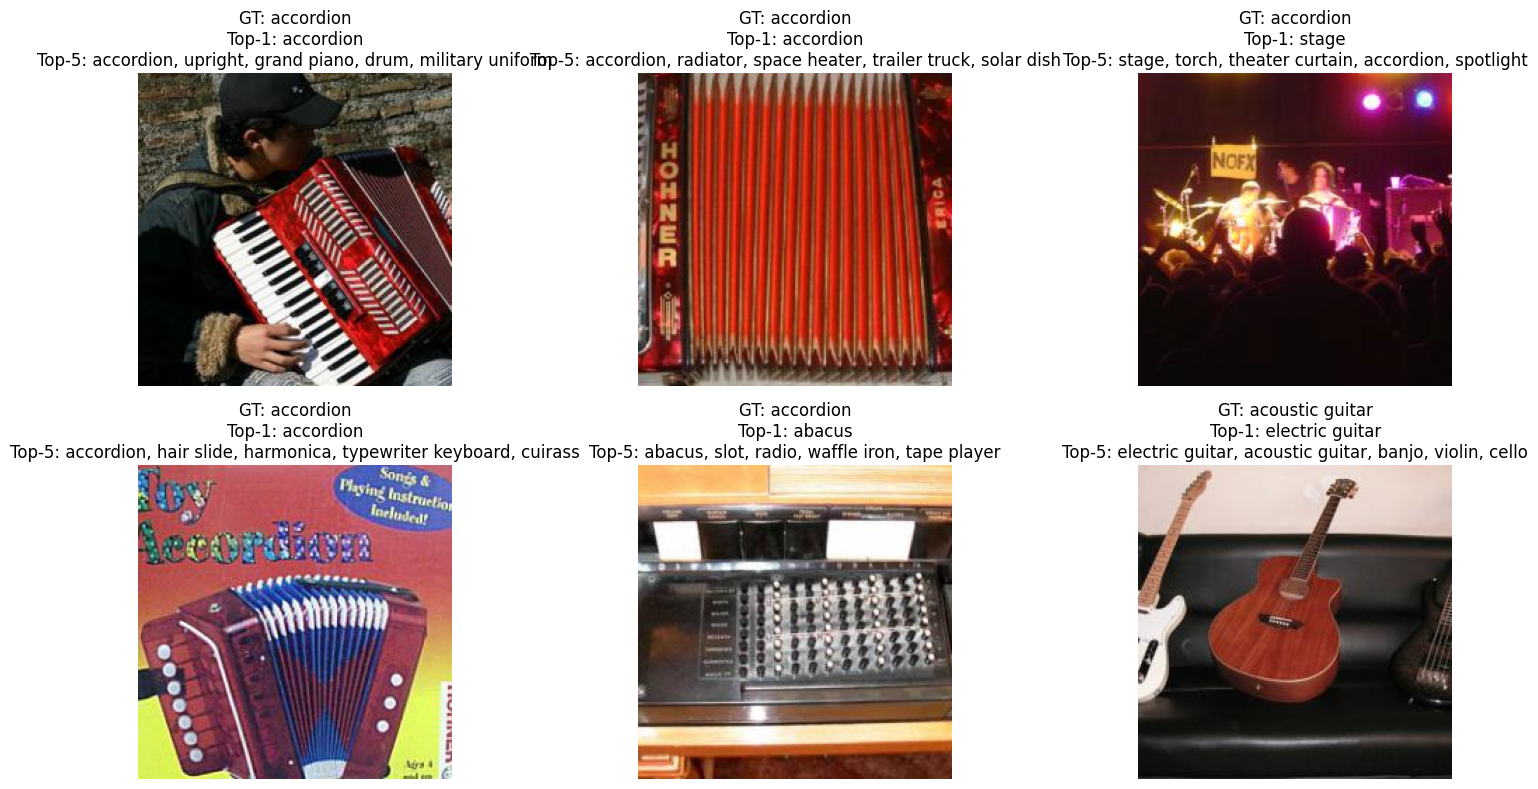

In [15]:
visualize_predictions()

In [16]:
def visualize_predictions_compact(num_samples=4):
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        top5_probs, top5_indices = probs.topk(5, dim=1)

    num_samples = min(num_samples, images.size(0))
    fig, axes = plt.subplots(2, num_samples, figsize=(4 * num_samples, 6))

    for i in range(num_samples):
        img = denormalize(images[i].cpu()).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        # Get ground truth and top-5 predictions
        gt_idx = class_to_imagenet_idx[labels[i].item()]
        gt_label = imagenet_idx_to_name.get(gt_idx, f"ID {gt_idx}")
        top5_idx = top5_indices[i].cpu().tolist()
        top5_prob = top5_probs[i].cpu().tolist()
        top5_labels = [imagenet_idx_to_name.get(idx, f"ID {idx}") for idx in top5_idx]

        # Plot image
        axes[0, i].imshow(img)
        axes[0, i].axis("off")
        axes[0, i].set_title(f"GT: {gt_label}", fontsize=10)

        # Plot bar graph
        axes[1, i].bar(top5_labels, top5_prob)
        axes[1, i].set_ylim(0, 1)
        axes[1, i].tick_params(axis='x', labelrotation=45)
        axes[1, i].set_title("Top-5", fontsize=9)
        axes[1, i].set_ylabel("Prob")

    plt.tight_layout()
    plt.show()

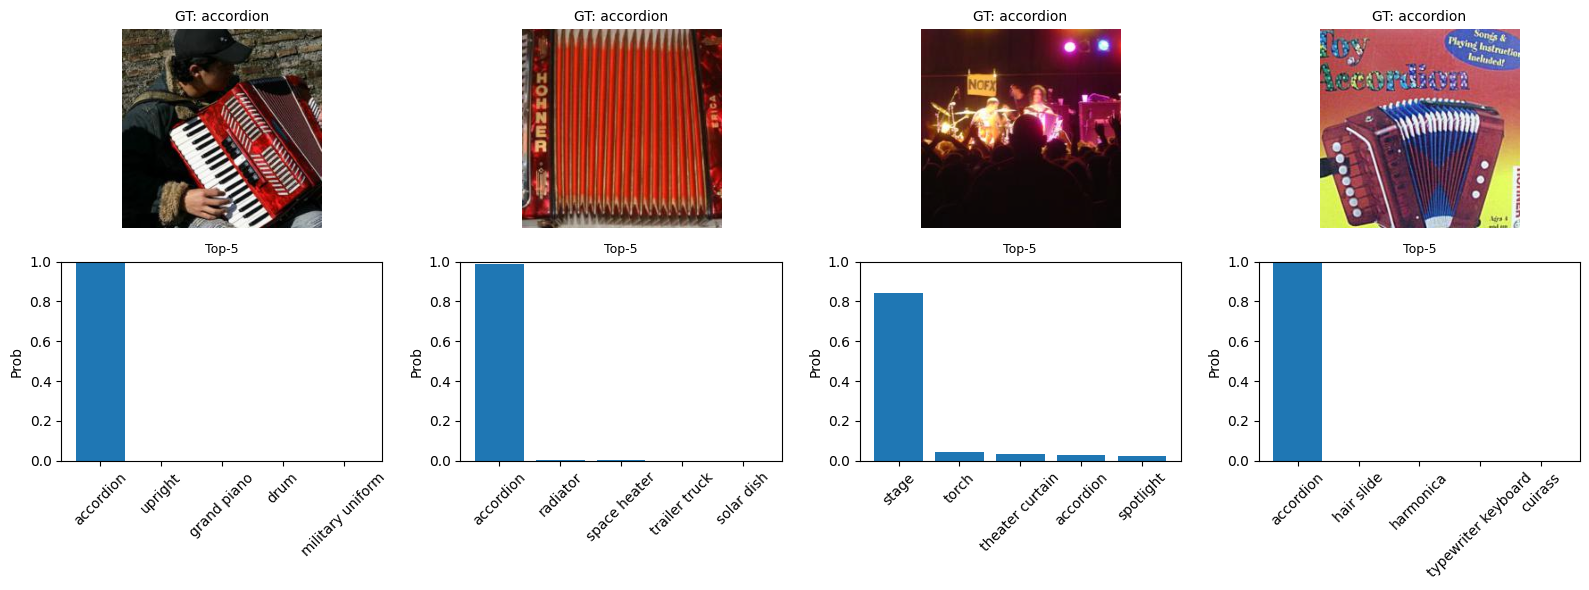

In [17]:
visualize_predictions_compact()

#### Task 2: Pixel-wise attacks

A common and simple algorithm for mounting an $L_\infty$ attack is called Fast Gradient Sign Method (FGSM); this implements a single step of gradient ascent (in pixel space) and truncates the values of the gradients to at most $\epsilon$. Mathematically, we can write this as:

$x \leftarrow x + \epsilon \cdot \text{sign}(\nabla_x L)$

Where $L$ is the cross-entropy loss, the gradient is with respect to the input parameters (not the weights — so remember to x), and the sign operation just truncates the gradient to the unit $L_\infty$ cube. (Convince yourself that this makes sense!)

The parameter $\epsilon$ is called the attack budget. If raw (unpreprocessed) images have pixel values of 0–255, an attack budget of $\epsilon = 0.02$ roughly corresponds to changing each pixel value in the raw image by at most ±1.

##### Step 1: Implement FGSM
Implement FGSM for each image in the test dataset for $\epsilon = 0.02$.

fsgm code: https://docs.pytorch.org/tutorials/beginner/fgsm_tutorial.html

fsgm ref: https://arxiv.org/abs/1412.6572

In [18]:
# https://docs.pytorch.org/tutorials/beginner/fgsm_tutorial.html
def fgsm_attack(image, epsilon, data_grad):
    # Get the sign of the gradients
    sign_data_grad = data_grad.sign()
    # Perturb the image by a small step in the gradient direction
    perturbed_image = image + epsilon * sign_data_grad
    # Clamp the image to maintain valid range after attack
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

##### Step 2: Visualize 3 to 5 test case
Visualize 3 to 5 test case where the original model no longer classifies as expected. Your visualization can be similar to the example shown above.

In [19]:
def visual(misclassified, denormalize, imagenet_idx_to_name):
    if not misclassified:
        print("No misclassified adversarial examples to show.")
        return

    n = len(misclassified)
    fig, axes = plt.subplots(3, n, figsize=(5 * n, 12))

    for i, ex in enumerate(misclassified):
        orig = denormalize(ex["orig"]).permute(1, 2, 0).numpy()
        adv = denormalize(ex["adv"]).permute(1, 2, 0).numpy()
        prob = F.softmax(ex["adv_out"], dim=0).numpy()
        top5p, top5i = np.sort(prob)[-5:], np.argsort(prob)[-5:]

        # Original
        axes[0, i].imshow(np.clip(orig, 0, 1))
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original\nGT: {ex['true']}", fontsize=10)

        # Adversarial
        axes[1, i].imshow(np.clip(adv, 0, 1))
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Adversarial\nPred: {ex['pred']}", fontsize=10)

        # Top-5 bar chart
        labels5 = [imagenet_idx_to_name[idx] for idx in top5i]
        axes[2, i].bar(labels5, top5p)
        axes[2, i].set_ylim(0, 1)
        axes[2, i].tick_params(axis='x', rotation=45)
        axes[2, i].set_title("Top‑5 Probabilities", fontsize=9)

    plt.tight_layout()
    plt.show()

##### Step 3: Save the dataset

You should now have a new set of 500 images:
- Verify that the new images are visually similar to the original test set.
- Ensure that the $L_\infty$ distance between new and original is no greater than $\epsilon = 0.02$.
-Save this dataset (call this **“Adversarial Test Set 1”**).

In [20]:
ADV_DIR = "AdversarialTestSet1"
epsilon = 0.02

In [21]:
def gen_adver1(model, test_loader, dataset, fgsm_attack, epsilon, class_to_imagenet_idx, imagenet_idx_to_name, denormalize, ADV_DIR, device):
    os.makedirs(ADV_DIR, exist_ok=True)
    for cls in dataset.classes:
        os.makedirs(os.path.join(ADV_DIR, cls), exist_ok=True)

    misclassified = []

    for batch_idx, (imgs, targets) in enumerate(tqdm(test_loader, desc="Generating Adversarials")):
        imgs, targets = imgs.to(device), targets.to(device)
        imgs.requires_grad = True

        outputs = model(imgs)
        true_idx = torch.tensor([class_to_imagenet_idx[t.item()] for t in targets], device=device)
        loss = F.cross_entropy(outputs, true_idx)
        model.zero_grad()
        loss.backward()

        adv_imgs = fgsm_attack(imgs, epsilon, imgs.grad.data).detach()

        with torch.no_grad():
            adv_out = model(adv_imgs)
            adv_top5 = adv_out.topk(5, dim=1)[1]
            adv_top1 = adv_top5[:, 0]

        for i in range(imgs.size(0)):
            cls_name = dataset.classes[targets[i].item()]
            save_path = os.path.join(ADV_DIR, cls_name, f"{batch_idx}_{i}.png")

            img_np = denormalize(adv_imgs[i].cpu()).permute(1, 2, 0).numpy()
            img_np = (np.clip(img_np, 0, 1) * 255).astype(np.uint8)
            Image.fromarray(img_np).save(save_path)

            if adv_top1[i] != true_idx[i] and len(misclassified) < 5:
                misclassified.append({
                    "orig": imgs[i].detach().cpu(),
                    "adv": adv_imgs[i].detach().cpu(),
                    "true": imagenet_idx_to_name[true_idx[i].item()],
                    "pred": imagenet_idx_to_name[adv_top1[i].item()],
                    "adv_out": adv_out[i].detach().cpu()
                })

    return misclassified

##### Step 4: Evaluate

Evaluate ResNet-34 performance and report:
- Top-1 accuracy
- Top-5 accuracy


In [22]:
def eval_adver_acc(model, ADV_DIR, class_to_imagenet_idx, plain_transforms, device):
    adv_dataset = ImageFolder(root=ADV_DIR, transform=plain_transforms)
    adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)

    top1_adv, top5_adv, tot = 0, 0, 0

    for imgs, targets in tqdm(adv_loader, desc="Evaluating Adversarial Accuracy"):
        imgs, targets = imgs.to(device), targets.to(device)

        with torch.no_grad():
            out = model(imgs)

        top5 = out.topk(5, dim=1)[1]
        top1 = top5[:, 0]
        true_idx = torch.tensor([class_to_imagenet_idx[t.item()] for t in targets], device=device)

        top1_adv += (top1 == true_idx).sum().item()
        top5_adv += sum([(true_idx[j].item() in top5[j].cpu().tolist()) for j in range(len(targets))])
        tot += targets.size(0)

    name = os.path.basename(ADV_DIR)
    print(f"\n🎯 {name} Accuracy:")
    print(f"Top-1: {100 * top1_adv / tot:.2f}%")
    print(f"Top-5: {100 * top5_adv / tot:.2f}%")
    fgsm_top1, fgsm_top5 = top1_adv / tot, top5_adv / tot
    return fgsm_top1, fgsm_top5

In [23]:
misclassified = gen_adver1(
    model, test_loader, dataset, fgsm_attack, epsilon,
    class_to_imagenet_idx, imagenet_idx_to_name, denormalize,
    ADV_DIR, device
)

Generating Adversarials: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


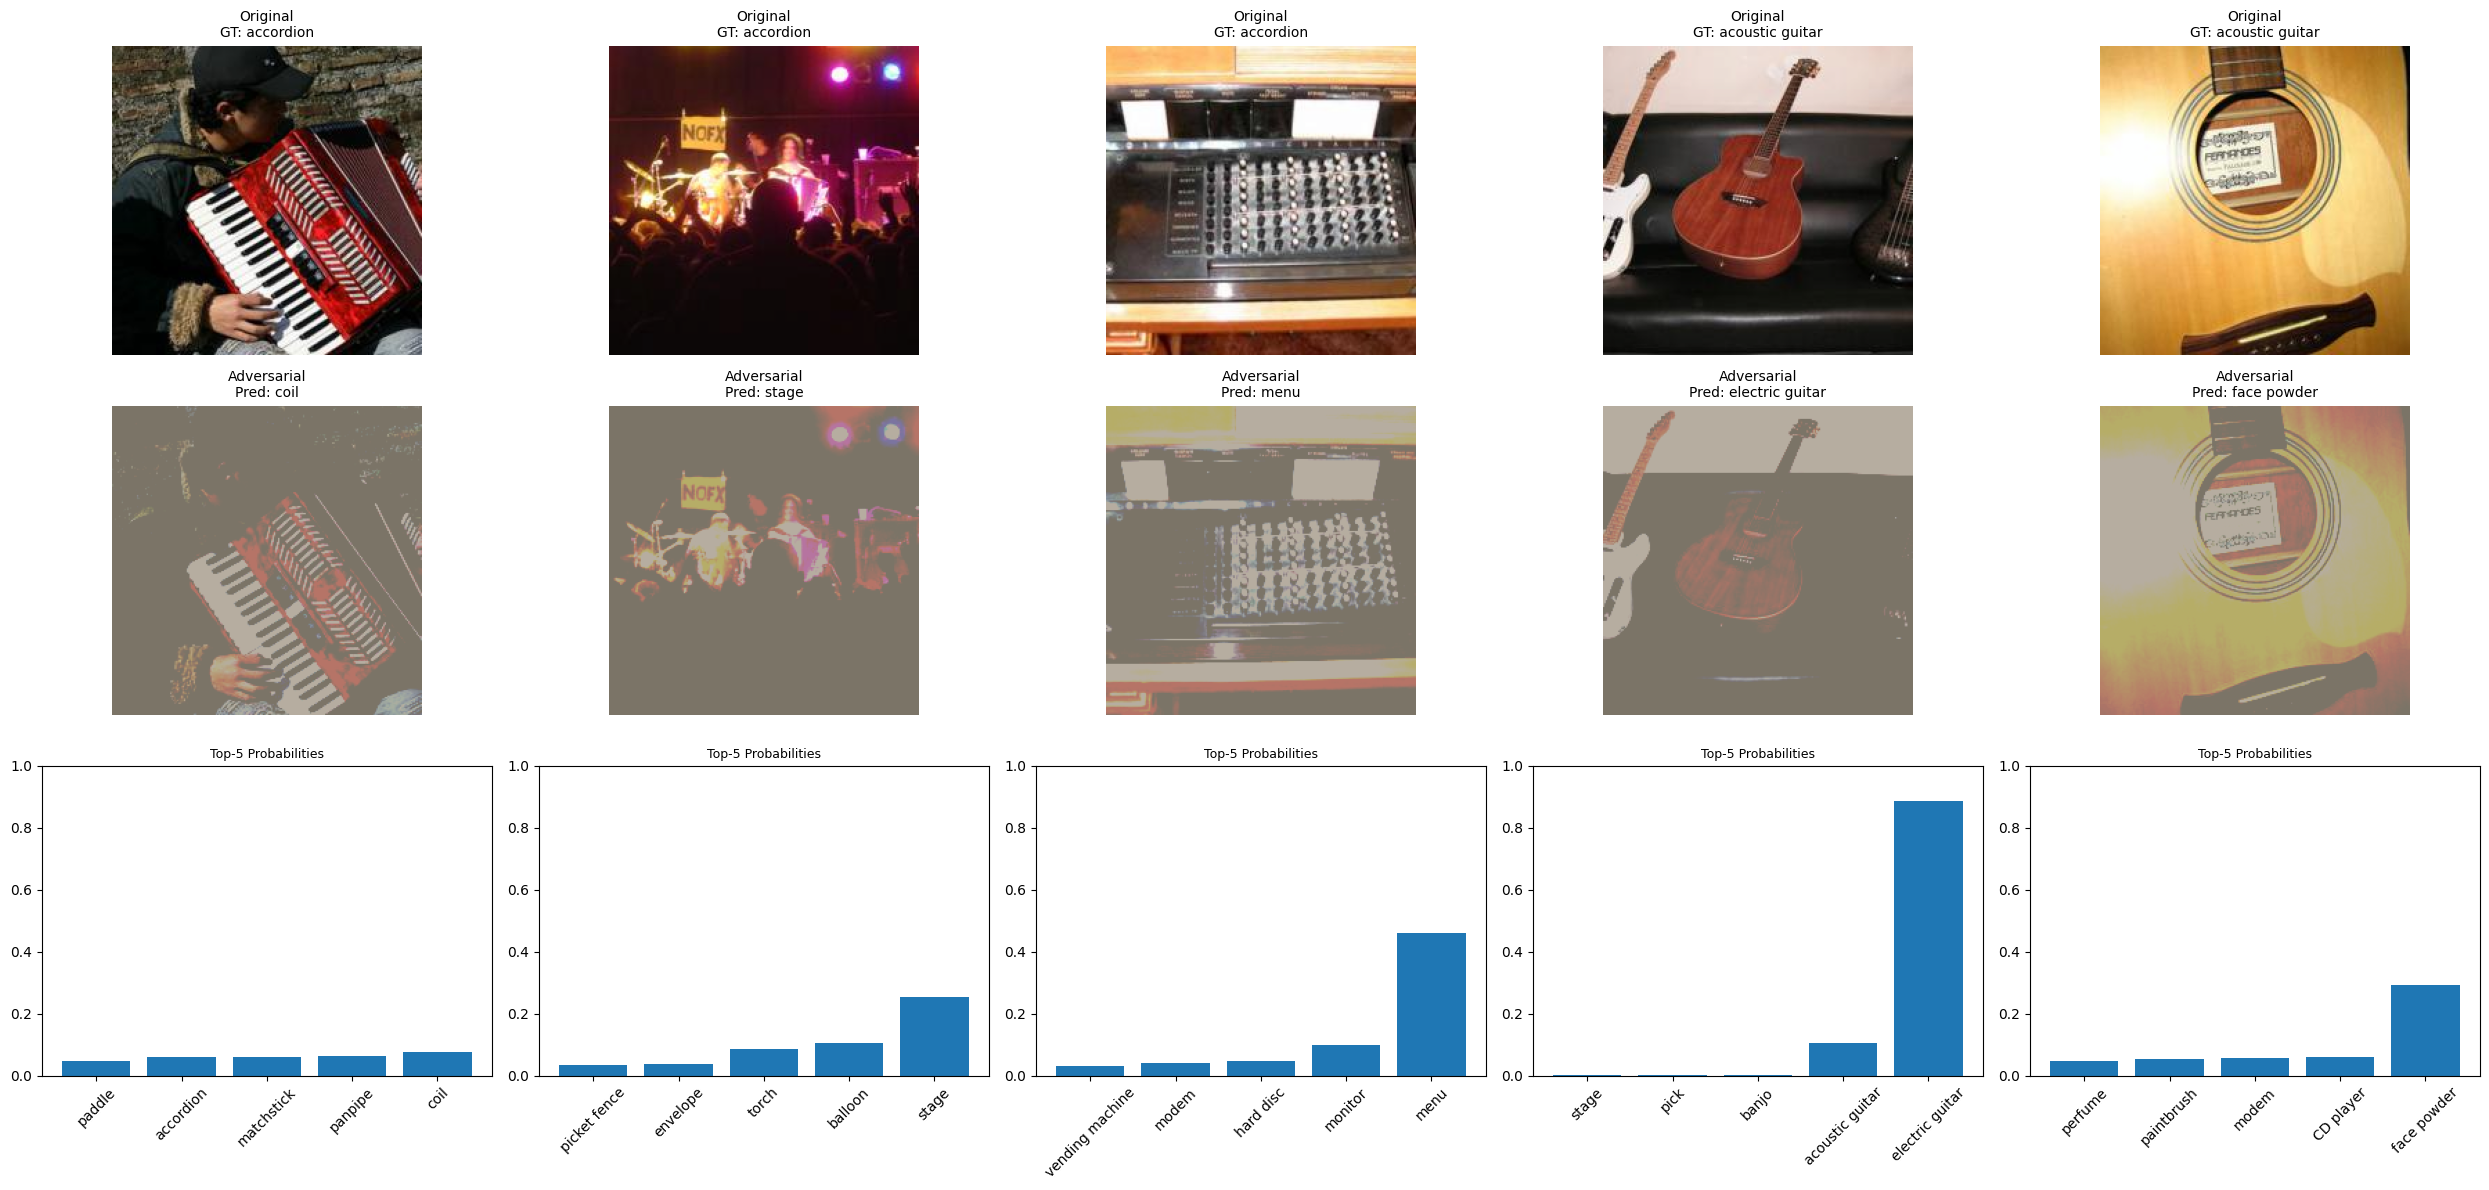

In [24]:
visual(
    misclassified, denormalize, imagenet_idx_to_name
)

In [25]:
fgsm_top1_acc, fgsm_top5_acc = eval_adver_acc(
    model, ADV_DIR, class_to_imagenet_idx, plain_transforms, device
)

Evaluating Adversarial Accuracy: 100%|██████████| 16/16 [00:01<00:00, 13.32it/s]


🎯 AdversarialTestSet1 Accuracy:
Top-1: 25.20%
Top-5: 47.60%


In [26]:
print(f"Adversarial Top-1 drop:  {100 * (baseline_top1_acc - fgsm_top1_acc):.2f}%")

print(f"Adversarial Top-5 drop:  {100 * (baseline_top5_acc - fgsm_top5_acc):.2f}%")

Adversarial Top-1 drop:  50.80%
Adversarial Top-5 drop:  46.60%


It should strive to achieve:
- Accuracy drop of at least 50% relative to your baseline numbers from Task 1.
- (So if your earlier metrics were above 80%, then your new metrics should be below 30%.)

#### Task 3: Improved attacks

Now that you have two accuracy metrics (one for the original test set, and one for Adversarial Test Set 1), propose ways to improve your attack and degrade performance even further.

 Remember: You can do whatever you like to the original test images, as long as the $\epsilon$ constraint is met and you get worse performance than FGSM.

Possible options include:
- Multiple gradient steps (e.g., Iterative FGSM)
- Targeted attacks
- Using other optimizers
- Momentum-based or projection-based techniques

ifgsm_attack code:
https://arxiv.org/abs/1607.02533

In [27]:
def ifgsm_attack(images, labels, model, epsilon=0.02, alpha=0.002, iters=10):
    adv_images = []
    for i in range(images.size(0)):
        img = images[i].unsqueeze(0).detach().clone().to(device).requires_grad_(True)
        label = labels[i].unsqueeze(0).to(device)
        original = img.clone().detach()

        for _ in range(iters):
            output = model(img)
            loss = F.cross_entropy(output, label)
            model.zero_grad()
            loss.backward()

            grad = img.grad.data.sign()
            img = img + alpha * grad
            img = torch.max(torch.min(img, original + epsilon), original - epsilon)
            img = torch.clamp(img, 0, 1).detach().requires_grad_(True)

        adv_images.append(img.detach())

    return torch.cat(adv_images)

##### Step 1: Create a new set of 500 adversarial images

- Ensure the images are visually similar to the original test set.
- Verify that the $L_\infty$ distance between the new and original images is no greater than $\epsilon = 0.02$.
- Save this dataset as **“Adversarial Test Set 2”**.

In [28]:
ADV_DIR2 = "AdversarialTestSet2"
def gen_adver(model, test_loader, dataset, attack_fn, epsilon,
                                  class_to_imagenet_idx, imagenet_idx_to_name,
                                  denormalize, ADV_DIR, device, iterative=False):
    os.makedirs(ADV_DIR, exist_ok=True)
    for cls in dataset.classes:
        os.makedirs(os.path.join(ADV_DIR, cls), exist_ok=True)

    misclassified = []

    for batch_idx, (imgs, targets) in enumerate(tqdm(test_loader, desc="Generating Adversarials")):
        imgs, targets = imgs.to(device), targets.to(device)

        true_idx = torch.tensor([class_to_imagenet_idx[t.item()] for t in targets], device=device)

        if iterative:
            adv_imgs = attack_fn(imgs, true_idx, model, epsilon=epsilon)
        else:
            imgs.requires_grad = True
            outputs = model(imgs)
            loss = F.cross_entropy(outputs, true_idx)
            model.zero_grad()
            loss.backward()
            adv_imgs = attack_fn(imgs, epsilon, imgs.grad.data).detach()

        with torch.no_grad():
            adv_out = model(adv_imgs)
            adv_top5 = adv_out.topk(5, dim=1)[1]
            adv_top1 = adv_top5[:, 0]

        for i in range(imgs.size(0)):
            cls_name = dataset.classes[targets[i].item()]
            save_path = os.path.join(ADV_DIR, cls_name, f"{batch_idx}_{i}.png")

            img_np = denormalize(adv_imgs[i].cpu()).permute(1, 2, 0).numpy()
            img_np = (np.clip(img_np, 0, 1) * 255).astype(np.uint8)
            Image.fromarray(img_np).save(save_path)

            if adv_top1[i] != true_idx[i] and len(misclassified) < 5:
                misclassified.append({
                    "orig": imgs[i].detach().cpu(),
                    "adv": adv_imgs[i].detach().cpu(),
                    "true": imagenet_idx_to_name[true_idx[i].item()],
                    "pred": imagenet_idx_to_name[adv_top1[i].item()],
                    "adv_out": adv_out[i].detach().cpu()
                })

    return misclassified

##### Step 2: Visuali 3 to 5 example images

showing the performance degradation compared to the original.

In [29]:
misclassified_2 = gen_adver(
    model=model,
    test_loader=test_loader,
    dataset=dataset,
    attack_fn=ifgsm_attack,
    epsilon=epsilon,
    class_to_imagenet_idx=class_to_imagenet_idx,
    imagenet_idx_to_name=imagenet_idx_to_name,
    denormalize=denormalize,
    ADV_DIR=ADV_DIR2,
    device=device,
    iterative=True
)

Generating Adversarials: 100%|██████████| 16/16 [01:15<00:00,  4.72s/it]


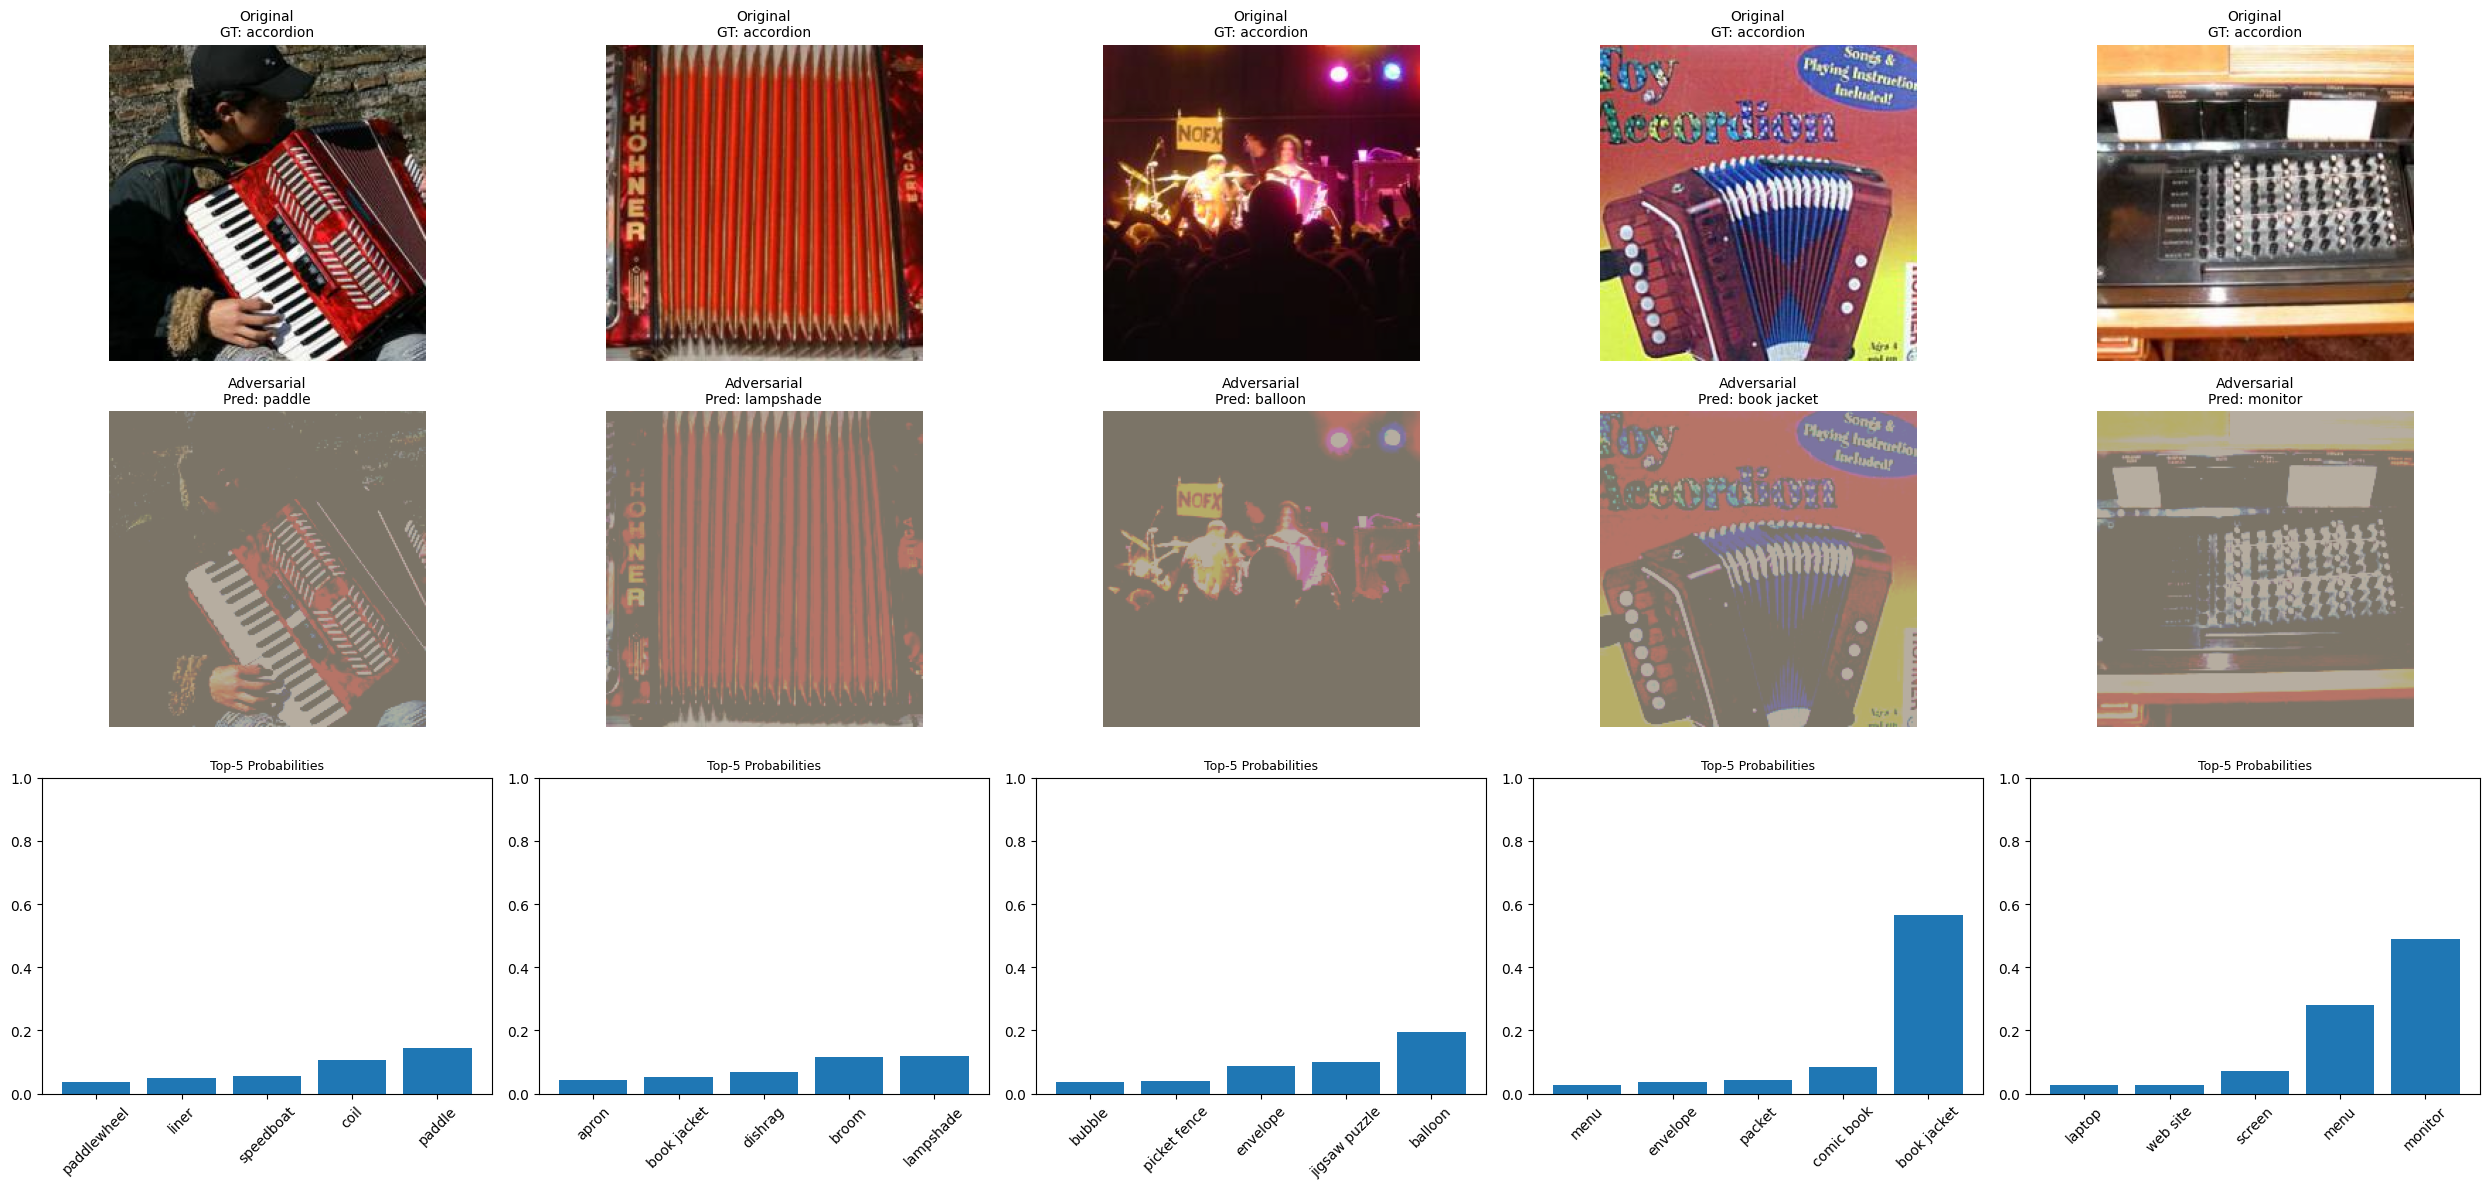

In [31]:
visual(
    misclassified_2, denormalize, imagenet_idx_to_name
)

##### Step 3: Evaluate

Evaluate ResNet-34 performance on Adversarial Test Set 2
- Top-1 accuracy
- Top-5 accuracy

In [32]:
fgsm2_top1_acc, fgsm2_top5_acc = eval_adver_acc(
    model, ADV_DIR2, class_to_imagenet_idx, plain_transforms, device
)

Evaluating Adversarial Accuracy: 100%|██████████| 16/16 [00:01<00:00, 13.28it/s]


🎯 AdversarialTestSet2 Accuracy:
Top-1: 1.00%
Top-5: 10.40%


In [33]:
print(f"Adversarial2 Top-1 drop:  {100 * (baseline_top1_acc - fgsm2_top1_acc):.2f}%")
print(f"Adversarial2 Top-5 drop:  {100 * (baseline_top5_acc - fgsm2_top5_acc):.2f}%")

Adversarial2 Top-1 drop:  75.00%
Adversarial2 Top-5 drop:  83.80%


You should strive to achieve accuracy drop of at least $70%$ relative to your baseline numbers from Task 1.

#### Task 4: Patch attacks
Pick your best-performing attack method so far, but modify it so that you’re only perturbing a small random patch (e.g., $32 \times 32$) in each test image instead of the entire image.

Guidelines:
- You may increase $\epsilon$ to a much larger amount (e.g., 0.3 or even 0.5) to make the attack effective.
- Consider using a targeted attack, which might be more successful in this constrained setting.

In [34]:
epsilon = 0.5
patch_size = 32

In [35]:
import random
def patch_ifgsm_attack(images, labels, model, epsilon=epsilon, alpha=0.05, iters=10, patch_size=patch_size):
    B, C, H, W = images.shape
    adv_images = []

    for i in range(B):
        img = images[i].unsqueeze(0).detach().clone().to(device)
        label = labels[i].unsqueeze(0).to(device)
        original = img.clone()

        # Sample top-left corner of 32×32 patch
        x = random.randint(0, H - patch_size)
        y = random.randint(0, W - patch_size)

        for _ in range(iters):
            img_patch = img.clone().detach().requires_grad_(True)

            output = model(img_patch)
            loss = F.cross_entropy(output, label)
            model.zero_grad()
            loss.backward()

            grad = img_patch.grad.data

            # Only modify the 32×32 patch
            perturbation = alpha * grad[:, :, x:x+patch_size, y:y+patch_size].sign()
            img[:, :, x:x+patch_size, y:y+patch_size] += perturbation

            # Keep within original ε-ball and clamp valid range
            img[:, :, x:x+patch_size, y:y+patch_size] = torch.clamp(
                torch.max(
                    torch.min(img[:, :, x:x+patch_size, y:y+patch_size], original[:, :, x:x+patch_size, y:y+patch_size] + epsilon),
                    original[:, :, x:x+patch_size, y:y+patch_size] - epsilon
                ),
                0, 1
            )

        adv_images.append(img.detach())

    return torch.cat(adv_images)

##### Step 1: Create a new adversarial dataset

- Apply perturbations only within a random $32 \times 32$ patch.
- Use your chosen attack method with a higher $\epsilon$ (e.g., 0.3 or 0.5).
- Save this dataset as **“Adversarial Test Set 3”**.


In [36]:
ADV_DIR3 = "AdversarialTestSet3"
misclassified_3 = gen_adver(
    model=model,
    test_loader=test_loader,
    dataset=dataset,
    attack_fn=patch_ifgsm_attack,
    epsilon=epsilon,
    class_to_imagenet_idx=class_to_imagenet_idx,
    imagenet_idx_to_name=imagenet_idx_to_name,
    denormalize=denormalize,
    ADV_DIR=ADV_DIR3,
    device=device,
    iterative=True
)

Generating Adversarials: 100%|██████████| 16/16 [01:19<00:00,  4.94s/it]


##### Step 2: Visuali 3 to 5 example images

showing how the patch attack affects classification.


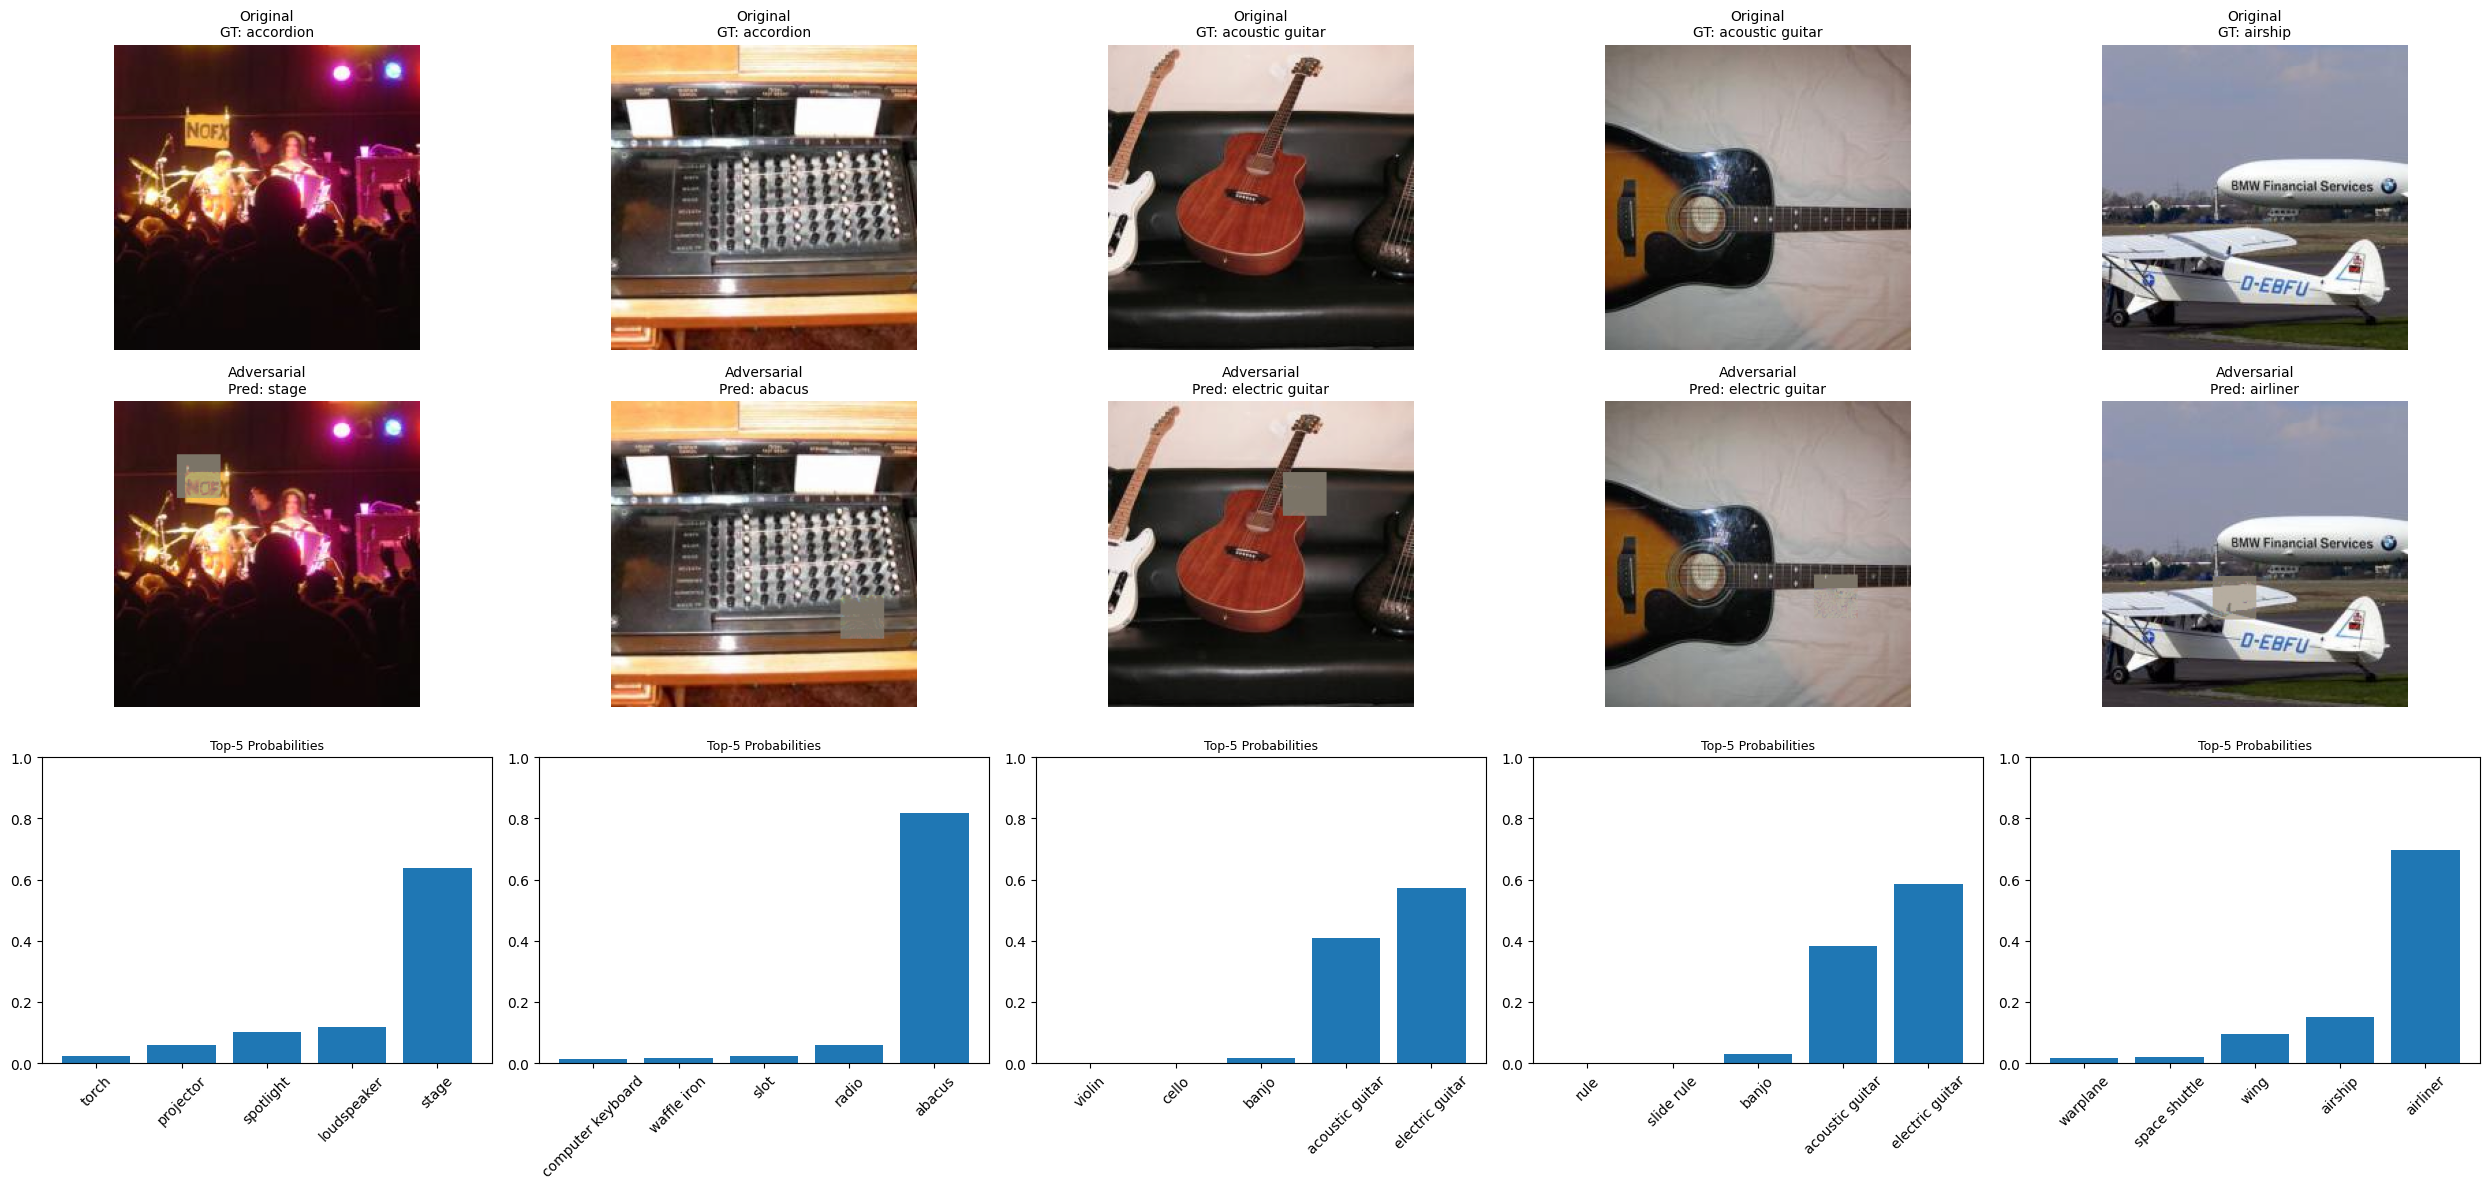

In [37]:
visual(
    misclassified_3, denormalize, imagenet_idx_to_name
)

##### Step 3: Evaluate

Evaluate ResNet-34 on Adversarial Test Set 3:
- Top-1 accuracy
- Top-5 accuracy

In [38]:
top1_patch, top5_patch = eval_adver_acc(
    model, ADV_DIR3, class_to_imagenet_idx, plain_transforms, device
)
print(f"Top-1 drop: {100 * (baseline_top1_acc - top1_patch):.2f}%")
print(f"Top-5 drop: {100 * (baseline_top5_acc - top5_patch):.2f}%")

Evaluating Adversarial Accuracy: 100%|██████████| 16/16 [00:01<00:00, 10.07it/s]


🎯 AdversarialTestSet3 Accuracy:
Top-1: 60.40%
Top-5: 88.40%
Top-1 drop: 15.60%
Top-5 drop: 5.80%


#### Task 5: Transferring Attacks
You now have three perturbed versions of the original test set. Your goal is to evaluate how well these adversarial examples transfer to other models.

##### Step 1: Choose a different pre-trained model

Choose a different pre-trained model for evaluation.
- exmaple: DenseNet-121
```python
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
```
A full list of ImageNet-1K models are available at this link.

In [39]:
from torchvision.models import densenet121

new_model = densenet121(weights='IMAGENET1K_V1')
new_model = new_model.to(device)
new_model.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 163MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

##### Step 2: Evaluate
Evalute the top-1 and top-5 accuracies on all 4 datasets:
- Original test set
- Adversarial Test Set 1 (FGSM)
- Adversarial Test Set 2 (Improved Attack)
- Adversarial Test Set 3 (Patch Attack)

In [40]:
datasets = {
    "Original": "TestDataSet",
    "FGSM": "AdversarialTestSet1",
    "Improved": "AdversarialTestSet2",
    "Patch": "AdversarialTestSet3"
}

results = {}

for name, path in datasets.items():
    print(f"\nEvaluating {name} on DenseNet-121")
    top1, top5 = eval_adver_acc(
        model=new_model,
        ADV_DIR=path,
        class_to_imagenet_idx=class_to_imagenet_idx,
        plain_transforms=plain_transforms,
        device=device
    )
    results[name] = {"Top-1": top1, "Top-5": top5}


Evaluating Original on DenseNet-121


Evaluating Adversarial Accuracy: 100%|██████████| 16/16 [00:01<00:00, 13.75it/s]



🎯 TestDataSet Accuracy:
Top-1: 74.60%
Top-5: 93.60%

Evaluating FGSM on DenseNet-121


Evaluating Adversarial Accuracy: 100%|██████████| 16/16 [00:01<00:00, 10.70it/s]



🎯 AdversarialTestSet1 Accuracy:
Top-1: 42.80%
Top-5: 66.60%

Evaluating Improved on DenseNet-121


Evaluating Adversarial Accuracy: 100%|██████████| 16/16 [00:01<00:00, 11.25it/s]



🎯 AdversarialTestSet2 Accuracy:
Top-1: 39.80%
Top-5: 64.00%

Evaluating Patch on DenseNet-121


Evaluating Adversarial Accuracy: 100%|██████████| 16/16 [00:01<00:00,  9.10it/s]


🎯 AdversarialTestSet3 Accuracy:
Top-1: 73.00%
Top-5: 92.40%


In [41]:
print("\n🔍 Transferability Results (ResNet-34 → DenseNet-121):")
print("{:<15} {:>10} {:>10}".format("Dataset", "Top-1", "Top-5"))
for name, metrics in results.items():
    print("{:<15} {:>9.2f}% {:>9.2f}%".format(
        name,
        100 * metrics["Top-1"],
        100 * metrics["Top-5"]
    ))


🔍 Transferability Results (ResNet-34 → DenseNet-121):
Dataset              Top-1      Top-5
Original            74.60%     93.60%
FGSM                42.80%     66.60%
Improved            39.80%     64.00%
Patch               73.00%     92.40%


##### Step 3: Report Results
- Any trends or patterns your observe across datasets and models
- Insights or lessons learned from the transferability of adversarial examples.
- Potential denfense strategies or methods to mitigate transferability.

**Conclusion:**
- I-FGSM has the strongest transferability, causing the biggest accuracy drop even on DenseNet-121.
- FGSM also transfers reasonably well but is weaker than the iterative verion
- Patch attacks barely transfers, from 74.60% drop to 72.80% is mostly unaffected. Since patch attacks perturb only a small region. and deseNet has different receptive field behavior than ResNet34.


**Thinking:**


So that full image attack like fgsm and i-fgsm often full multiple models.
is transferability symmetric, since adversarial example generated on ResNet-34 might transfer to DenseNet-121, but can it do reverse way?
